In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import pandas as pd

2024-12-23 11:56:46.031196: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-23 11:56:46.044397: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734951406.058805   23311 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734951406.062785   23311 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-23 11:56:46.078352: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
stats = pd.read_csv("image_dimensions.csv")
stats.set_index("Unnamed: 0", inplace=True)
stats.index.name = None
stats

,widths,heights
count,2800.000000,2800.000000
mean,603.034286,647.997143
std,415.862944,446.696660
min,106.000000,115.000000
25%,313.000000,383.000000
50%,547.500000,589.500000
75%,800.000000,826.000000
max,7264.000000,6017.000000
median,547.500000,589.500000


In [ ]:
median_width = int(stats.loc["median", "widths"])
median_height = int(stats.loc["median", "heights"])

In [4]:
def build_model(width, height):
    model = keras.Sequential([
        layers.InputLayer(shape=(width, height, 3)),
        layers.Rescaling(1./255),
        layers.Conv2D(32, 3, activation='relu'),
        layers.MaxPooling2D(pool_size=2),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(pool_size=2),
        layers.Conv2D(128, 3, activation='relu'),
        layers.MaxPooling2D(pool_size=2),
        layers.Conv2D(256, 3, activation='relu'),
        layers.MaxPooling2D(pool_size=2),
        layers.Conv2D(512, 3, activation='relu'),
        layers.MaxPooling2D(pool_size=2),
        layers.Conv2D(512, 3, activation='relu'),
        layers.MaxPooling2D(pool_size=2),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid'),
    ])
    return model

model = build_model(median_width, median_height)
model.summary()


I0000 00:00:1734951409.292436   23311 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5582 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 547, 589, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 545, 587, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 272, 293, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 270, 291, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 135, 145, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 133, 143, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 66, 71, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 69, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 34, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 30, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 15, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 13, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 21504)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        21,505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,949,889 (15.07 MB)

 Trainable params: 3,949,889 (15.07 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
def plot_info(axes, type):
    axes.set_title(type)
    axes.set_xlabel("Epochs")
    axes.set_ylabel("Loss")
    axes.legend()
    axes.grid()

def plot_loss(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    epochs_range = range(1, len(history.history["loss"]) + 1)

    _, axes = plt.subplots(4,1, figsize=(12,18))
    axes[0].plot(epochs_range, loss, label="Training loss")
    axes[0].plot(epochs_range, val_loss, label="Validation loss")
    plot_info(axes[0], "Lineair")
    

    axes[1].semilogy(epochs_range, loss, label="Training loss")
    axes[1].semilogy(epochs_range, val_loss, label="Validation loss")
    plot_info(axes[1], "Logarithmic")

    axes[2].plot(epochs_range, acc, label="Training accuracy")
    axes[2].plot(epochs_range, val_acc, label="Validation accuracy")
    plot_info(axes[2], "Lineair")

    axes[3].semilogy(epochs_range, acc, label="Training accuracy")
    axes[3].semilogy(epochs_range, val_acc, label="Validation accuracy")
    plot_info(axes[3], "Logarithmic")

In [6]:
def load_subdataset(base_dir, subdataset, painters, width, height):
    train_datagen = ImageDataGenerator(rescale=1./255) #Uitzoeken
    train_generator = train_datagen.flow_from_directory(
        f'{base_dir}/{subdataset}',
        target_size=(width, height),
        batch_size=16,
        class_mode='binary', 
        classes=painters,
    )    
    return train_generator


def load_dataset(base_dir, painters, width, height):
    train_generator = load_subdataset(base_dir, "train", painters, width, height)
    validation_generator = load_subdataset(base_dir, "validation", painters, width, height)
    test_generator = load_subdataset(base_dir, "test", painters, width, height)
    return train_generator, validation_generator, test_generator

In [7]:
def load_dataset(base_dir, painters, width, height, batch_size=16):
    train_dataset = image_dataset_from_directory(
        f'{base_dir}/train',
        labels='inferred',
        label_mode='int',
        class_names=painters,
        image_size=(width, height),
        batch_size=batch_size,
    )
    validation_dataset = image_dataset_from_directory(
        f'{base_dir}/validation',
        labels='inferred',
        label_mode='int',
        class_names=painters,
        image_size=(width, height),
        batch_size=batch_size,
    )
    test_dataset = image_dataset_from_directory(
        f'{base_dir}/test',
        labels='inferred',
        label_mode='int',
        class_names=painters,
        image_size=(width, height),
        batch_size=batch_size,
    )
    return train_dataset, validation_dataset, test_dataset

## Undersampled dataset:

### Data inladen:

In [8]:
painters = ["Mondriaan", "Picasso"]
train, val, test = load_dataset("undersampled_dataset", painters, median_width, median_height)

Found 310 files belonging to 2 classes.
Found 102 files belonging to 2 classes.
Found 102 files belonging to 2 classes.


### Model trainen

In [9]:
model = build_model(median_width, median_height)
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.1), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 547, 589, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 545, 587, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 272, 293, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 270, 291, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 135, 145, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 133, 143, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 66, 71, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 69, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 32, 34, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 30, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 15, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 13, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 6, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 21504)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        21,505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,949,889 (15.07 MB)

 Trainable params: 3,949,889 (15.07 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
callbacks = [keras.callbacks.ModelCheckpoint(filepath="model_undersampled.keras", save_best_only=True, monitor="val_loss")]

history = model.fit(train, epochs=20, validation_data=val, callbacks=callbacks)

Epoch 1/20


I0000 00:00:1734951413.738881   23420 service.cc:148] XLA service 0x7fa7f400c560 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734951413.740068   23420 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2024-12-23 11:56:53.795570: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734951414.212679   23420 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/20 ━━━━━━━━━━━━━━━━━━━━ 4:35 14s/step - accuracy: 0.6875 - loss: 0.6906

I0000 00:00:1734951427.047542   23420 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 672ms/step - accuracy: 0.5356 - loss: 13586199552.0000 - val_accuracy: 0.5000 - val_loss: 50147.5508
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 0.4997 - loss: 18366.1035 - val_accuracy: 0.5000 - val_loss: 3866.3596
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 0.5011 - loss: 1958.7421 - val_accuracy: 0.5000 - val_loss: 253.7520
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 0.5386 - loss: 107.4233 - val_accuracy: 0.5196 - val_loss: 10.9771
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.4266 - loss: 6.5329 - val_accuracy: 0.5000 - val_loss: 3.8932
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 0.4862 - loss: 1.8023 - val_accuracy: 0.4902 - val_loss: 2.3182
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.5106 - loss: 1.2899 - val_accuracy: 0.5000 - val_loss: 3.1285
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 0.4476 - loss: 1.3677

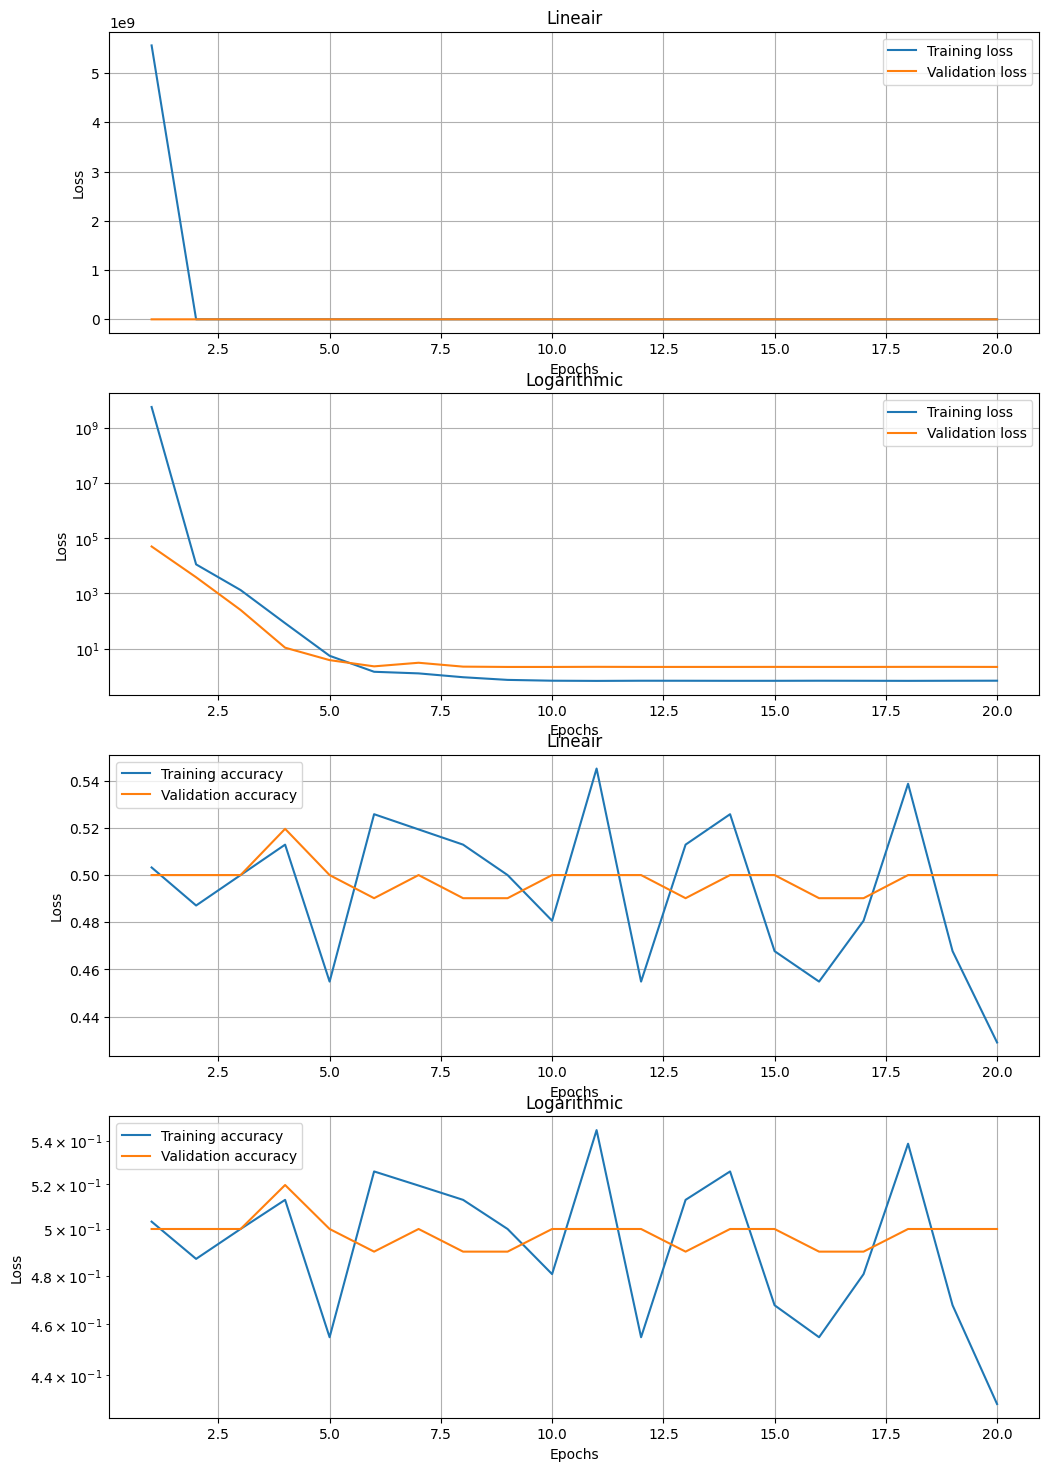

In [11]:
plot_loss(history)

In [12]:
y_pred = model.predict(test)
y_pred = np.where(y_pred > 0.5, 1, 0)
y_true = np.concatenate([y.numpy() for _, y in test], axis=0)
print(classification_report(y_true, y_pred, zero_division=0))

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step
              precision    recall  f1-score   support

           0       0.50      1.00      0.67        51
           1       0.00      0.00      0.00        51

    accuracy                           0.50       102
   macro avg       0.25      0.50      0.33       102
weighted avg       0.25      0.50      0.33       102



2024-12-23 11:58:10.968703: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Oversampled dataset

### loading data

In [14]:
train, val, test = load_dataset("oversampled_dataset", painters, median_height, median_width, batch_size=8)
model = build_model(median_width, median_height)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
callbacks = [keras.callbacks.ModelCheckpoint(filepath="model_oversampled.keras", save_best_only=True, monitor="val_loss")]
history = model.fit(train, epochs=20, validation_data=val, callbacks=callbacks)

Found 1834 files belonging to 2 classes.
Found 610 files belonging to 2 classes.
Found 610 files belonging to 2 classes.
Epoch 1/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 40s 112ms/step - accuracy: 0.5200 - loss: 0.8675 - val_accuracy: 0.5000 - val_loss: 1.3797
Epoch 2/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 19s 81ms/step - accuracy: 0.5958 - loss: 0.7050 - val_accuracy: 0.5508 - val_loss: 0.6950
Epoch 3/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.6908 - loss: 0.5992 - val_accuracy: 0.7426 - val_loss: 0.4634
Epoch 4/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 18s 77ms/step - accuracy: 0.7647 - loss: 0.5585 - val_accuracy: 0.8721 - val_loss: 0.3212
Epoch 5/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 18s 80ms/step - accuracy: 0.8309 - loss: 0.3862 - val_accuracy: 0.7836 - val_loss: 0.4448
Epoch 6/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - accuracy: 0.8697 - loss: 0.3628 - val_accuracy: 0.9262 - val_loss: 0.2032
Epoch 7/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 17s 74ms/step - accuracy: 0.9112 - loss: 0.2602 - val_accu

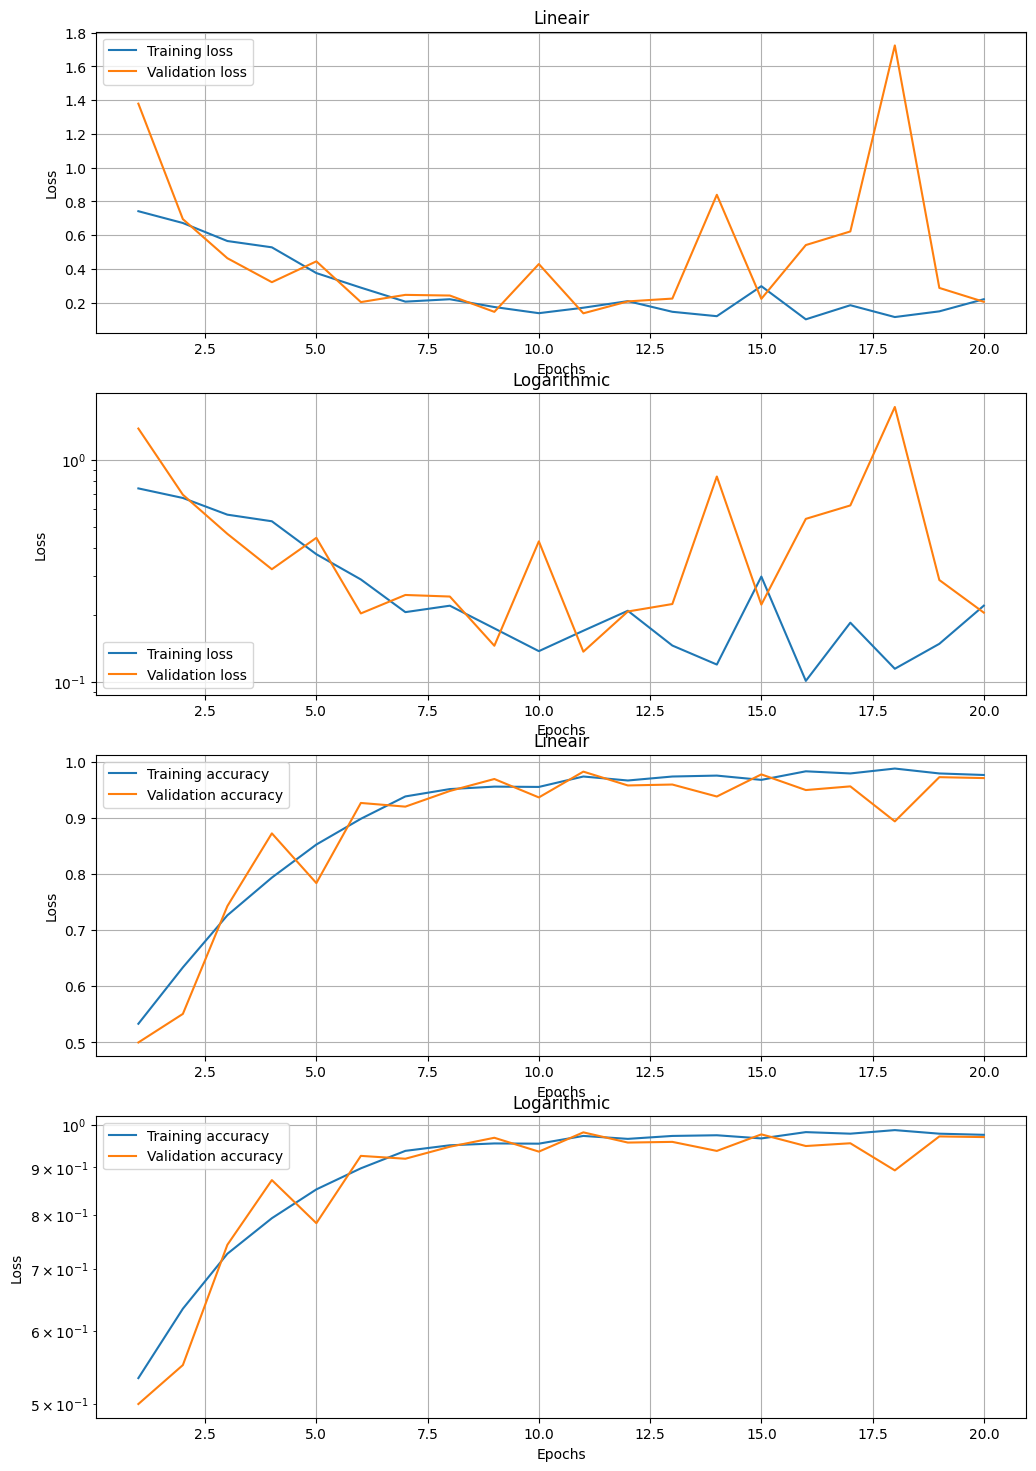

In [15]:
plot_loss(history)

In [16]:
y_pred = model.predict(test)
y_pred = np.where(y_pred > 0.5, 1, 0)
y_true = np.concatenate([y.numpy() for _, y in test], axis=0)
print(classification_report(y_true, y_pred, zero_division=0))

77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step
              precision    recall  f1-score   support

           0       0.53      0.54      0.53       305
           1       0.53      0.51      0.52       305

    accuracy                           0.53       610
   macro avg       0.53      0.53      0.53       610
weighted avg       0.53      0.53      0.53       610



2024-12-23 12:10:22.969680: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## imbalanced dataset

### loading dataset

In [1]:
train, val, test = load_dataset("imbalanced_dataset", painters, median_width, median_height, batch_size=2)

NameError: name 'load_dataset' is not defined

### Fitting model 

Mondriaan = 0, Picasso = 1

In [18]:
train.class_names

['Mondriaan', 'Picasso']

In [19]:
class_counts = {}

for _, labels in train:
    for label in labels.numpy():
        class_counts[label] = class_counts.get(label, 0) + 1

total = sum(class_counts.values())
total, class_counts

(1115, {np.int32(1): 917, np.int32(0): 198})

In [20]:
mondriaan_count = class_counts.get(0, 0)  
picasso_count = class_counts.get(1, 0)   

weight_for_0 = float((1 / mondriaan_count) * (total / 2.0)) if mondriaan_count > 0 else 0
weight_for_1 = float((1 / picasso_count) * (total / 2.0)) if picasso_count > 0 else 0
class_weight = {0: weight_for_0, 1: weight_for_1}

class_weight


{0: 2.8156565656565657, 1: 0.6079607415485279}

In [21]:
model = build_model(median_width, median_height)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
callbacks = [keras.callbacks.ModelCheckpoint(filepath="model_imbalanced.keras", save_best_only=True, monitor="val_loss")]
model.fit(train, epochs=20, validation_data=val, callbacks=callbacks, class_weight=class_weight)

Epoch 1/20


2024-12-23 12:11:10.829441: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30929952 bytes after encountering the first element of size 30929952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


: 

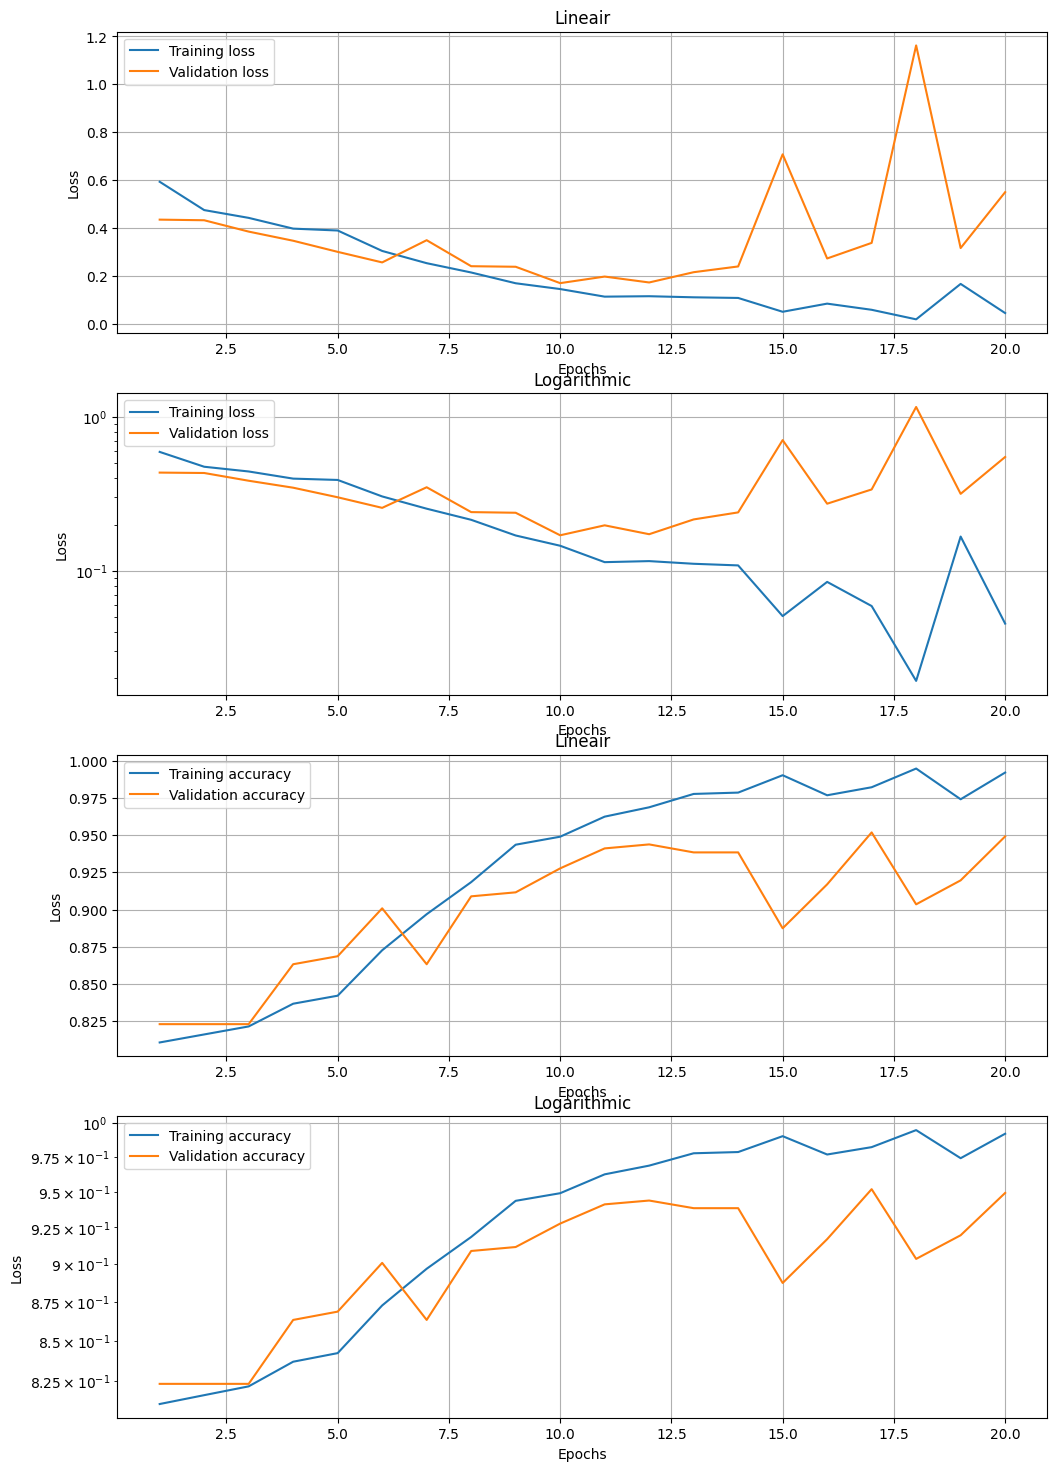

In [ ]:
plot_loss(history)

In [45]:
y_pred = model.predict(test_generator)
y_pred = np.round(y_pred)
y_true = test_generator.classes
print(classification_report(y_true, y_pred))

/home/timmo/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 542ms/step
              precision    recall  f1-score   support

           0       0.18      0.18      0.18        66
           1       0.82      0.82      0.82       305

    accuracy                           0.70       371
   macro avg       0.50      0.50      0.50       371
weighted avg       0.71      0.70      0.71       371



Image size bepalen

minimum

In [55]:
min_width = 106 	 
min_height = 115
image_size = (min_width, min_height)

In [56]:
train_generator, val_generator, test_generator = load_dataset("imbalanced_dataset", painters, min_width, min_height)
images, labels = next(train_generator)
print(f"Image batch shape: {images.shape}")
print(f"Label batch shape: {labels.shape}")
print(f"Single image shape: {images[0].shape}")

Found 1115 images belonging to 2 classes.
Found 373 images belonging to 2 classes.
Found 371 images belonging to 2 classes.
Image batch shape: (16, 106, 115, 3)
Label batch shape: (16,)
Single image shape: (106, 115, 3)


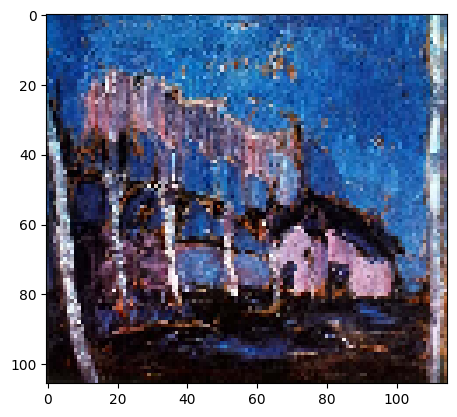

In [58]:
plt.imshow(images[0])

In [ ]:
model = build_model(min_width, min_height)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
model.fit(train_generator, epochs=20, validation_data=val_generator)